In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import os

In [96]:
classes = {'n01440764':0, 'n02102040':1,'n02979186':2,'n03000684':3,'n03028079':4,'n03394916':5,'n03417042':6,'n03425413':7,'n03445777':8,'n03888257':9}
class Imagenette(Dataset):
    def __init__(self, txt_path, img_dir, transform=None, train=True, noisy_labels = 'noisy_labels_0', target_transform=None):
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.train = train
        if train:
            df = df[df.is_valid == False]
        else:
            df = df[df.is_valid == True]
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df[noisy_labels].values
        self.transform = transform
        self.target_transform = target_transform
        
        
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        if img.mode == 'L':
            img = img.convert(mode='RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = torch.tensor(classes[self.y[index]])
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [116]:
transform_train = transforms.Compose([
    transforms.Resize(31,max_size=32),
    # transforms.RandomCrop(200, pad_if_needed=True),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(31,max_size=32),
    # transforms.RandomCrop(200, pad_if_needed=True),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

batch_size = 64
block = 3 


# target_transform = transforms.Compose([
#     transforms.ToTensor()
# ])

torch.manual_seed(43)

trainset = Imagenette(txt_path='imagenette2-160/noisy_imagenette.csv', train=True, 
                              img_dir='imagenette2-160/',
                              transform=transform_train, #target_transform = target_transform)
                     )
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=8,
                                            prefetch_factor = 2,
                                            pin_memory = True)

testset = Imagenette(txt_path='imagenette2-160/noisy_imagenette.csv', train=False, 
                              img_dir='imagenette2-160/',
                              transform=transform_test, #target_transform = target_transform)
                    )
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform_train)
# train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                             shuffle=True, num_workers=8,
#                                             prefetch_factor = 2, 
#                                             pin_memory = True)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform_test)
# test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                              shuffle=False, num_workers=8,
#                                              prefetch_factor = 2, 
#                                             pin_memory = True)

val_dl = test_dl
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [117]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


images.shape: torch.Size([64, 3, 32, 32])


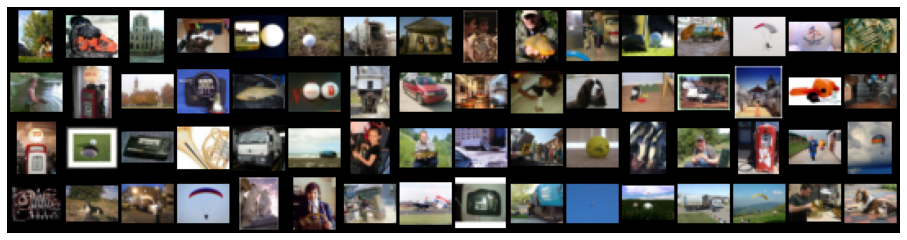

In [118]:
for images, _ in train_dl:
    # print(images)
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

images.shape: torch.Size([64, 3, 32, 32])


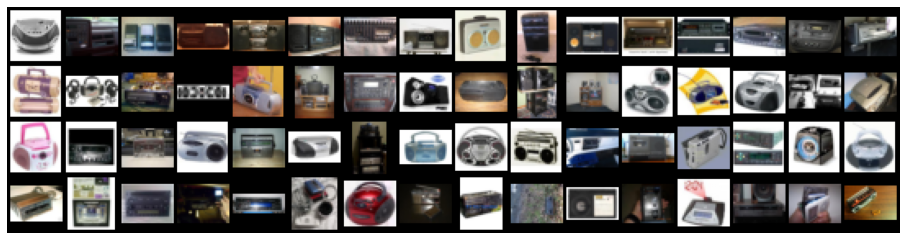

In [119]:
for images, _ in test_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [120]:
from torch import Tensor
def sce(pred, labels, alpha, beta, num_classes, device):
    cross_entropy = torch.nn.CrossEntropyLoss()
    # CCE
    ce = cross_entropy(pred, labels)

    # RCE
    pred = F.softmax(pred, dim=1)
    pred = torch.clamp(pred, min=1e-7, max=1.0)
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes).float().to(device)
    label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
    rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

    # Loss
    loss = alpha * ce + beta * rce.mean()
    return loss
class SCELoss(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(SCELoss, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, pred, labels) -> Tensor:
        return sce(pred, labels, self.alpha, self.beta, self.num_classes, self.device)
        
        
        

In [121]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        # Set first filter  
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        
        # He initialization: 
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter 
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')
        
        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')

        #nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.pool = nn.MaxPool2d(2, 2)
        
        if block is 1:
          self.fc1 = nn.Linear(8192, 120)
          self.fc2 = nn.Linear(120, 10) # CHANGE 
          self.fc3 = nn.Linear(84, 10)
        else:  
          self.fc1 = nn.Linear(2048, 400)
          nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        
          self.fc2 = nn.Linear(400, 10) # CHANGE 
          self.fc3 = nn.Linear(400, 10)

    def forward(self, x):
        if block is 1:  
          # 1 VGG block: 
          x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
        else:
          # 3 VGG block 
          x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
          x = self.pool(F.relu(self.conv2_2(F.relu(self.conv2_1(x)))))
          x = self.pool(F.relu(self.conv3_2(F.relu(self.conv3_1(x)))))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc3(x)

        #x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        #x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))

        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x


model = VGG() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu
## Loss and optimizer
learning_rate = 0.001 #I picked this because it seems to be the most used by experts
load_model = True
criterion = nn.CrossEntropyLoss()

# criterion = SCELoss(1, 1, 10)
optimizer = optim.SGD(model.parameters(), lr= learning_rate,momentum=0.9) #Adam seems to be the most popular for deep learning
#optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [123]:
loss_store_train =[]
loss_store_val = []
acc_store=[]
epoches=100
xaxis=np.arange(0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    # class_correct = [0 for i in range(0.10)]
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
                
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

Loss in epoch 0: 2.043
Got 1320 / 3925 with accuracy 33.63
Loss in epoch 1: 1.861
Got 1507 / 3925 with accuracy 38.39
Loss in epoch 2: 1.722
Got 1594 / 3925 with accuracy 40.61
Loss in epoch 3: 1.630
Got 1815 / 3925 with accuracy 46.24
Loss in epoch 4: 1.554
Got 1854 / 3925 with accuracy 47.24
Loss in epoch 5: 1.464
Got 1963 / 3925 with accuracy 50.01
Loss in epoch 6: 1.391
Got 2081 / 3925 with accuracy 53.02
Loss in epoch 7: 1.347
Got 2075 / 3925 with accuracy 52.87
Loss in epoch 8: 1.293
Got 2112 / 3925 with accuracy 53.81
Loss in epoch 9: 1.241
Got 2124 / 3925 with accuracy 54.11
Loss in epoch 10: 1.172
Got 2150 / 3925 with accuracy 54.78
Loss in epoch 11: 1.121
Got 2229 / 3925 with accuracy 56.79
Loss in epoch 12: 1.061
Got 2229 / 3925 with accuracy 56.79
Loss in epoch 13: 1.039
Got 2284 / 3925 with accuracy 58.19
Loss in epoch 14: 0.976
Got 2219 / 3925 with accuracy 56.54
Loss in epoch 15: 0.926
Got 2225 / 3925 with accuracy 56.69
Loss in epoch 16: 0.856
Got 2181 / 3925 with accur

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

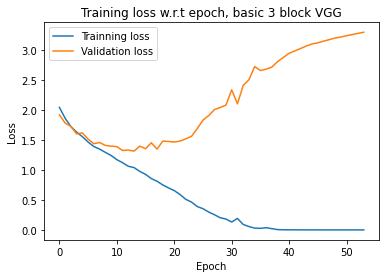

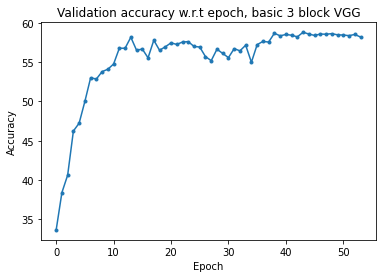

In [124]:

plt.figure(1)
plt.plot(loss_store_train,label = 'Trainning loss')
plt.plot(loss_store_val, label = 'Validation loss') 
plt.legend() 
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training loss w.r.t epoch, basic 3 block VGG') 
plt.figure(2)
plt.plot(acc_store,marker='.')
plt.title('Validation accuracy w.r.t epoch, basic 3 block VGG') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

In [12]:
PATH = './cifar_net_baseline.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
dataiter = iter(test_dl)
images, labels = dataiter.next()

# print images
plt.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
net = VGG()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
        f"Accuracy of the network on the 10000 test images: {float(correct) / float(total) * 100:.2f}%"
)

NameError: name 'images' is not defined